In [1]:
with open("../Figures/COVID/AA_sequence_combined.txt") as f:
    sarscov2_combined = f.read().strip()

In [2]:
from pepdata import iedb

In [3]:
df_mhc = iedb.mhc.load_dataframe()

In [4]:
df_tcell = iedb.tcell.load_dataframe()

                      Reference                                     \
                      Assay IRI                      Reference IRI   
0  http://www.iedb.org/assay/29  http://www.iedb.org/reference/274   
1  http://www.iedb.org/assay/37  http://www.iedb.org/reference/281   
2  http://www.iedb.org/assay/42  http://www.iedb.org/reference/283   
3  http://www.iedb.org/assay/43  http://www.iedb.org/reference/283   
4  http://www.iedb.org/assay/47  http://www.iedb.org/reference/275   

                                                                              \
         Type   PubMed ID                                            Authors   
0  Literature  15448372.0  Yi-Hsiang Huang; Mi-Hua Tao; Cheng-po Hu; Wan-...   
1  Literature   7684468.0  V J La Posta; D D Auperin; R Kamin-Lewis; G A ...   
2  Literature  15634878.0    Evan R Jellison; Sung-Kwon Kim; Raymond M Welsh   
3  Literature  15634878.0    Evan R Jellison; Sung-Kwon Kim; Raymond M Welsh   
4  Literature  15519708.0  Ol

In [15]:
mhc_organisms = set(df_mhc["Epitope"]["Organism Name"].unique())

In [16]:
tcell_organisms = set(df_tcell["Epitope"]["Organism Name"].unique())

In [29]:
for o in mhc_organisms:
    if type(o) is str and "SARS" in o:
        print(o)
    if type(o) is str and "respiratory syndrome" in o.lower().replace("-", " "):
        print(">", o)

SARS coronavirus Tor2
Bat SARS CoV Rp3/2004
SARS-related coronavirus
SARS coronavirus Urbani
> Middle East respiratory syndrome-related coronavirus
> Porcine reproductive and respiratory syndrome virus
SARS coronavirus TJF
SARS coronavirus
SARS coronavirus BJ01


In [30]:
for o in tcell_organisms:
    if type(o) is str and "SARS" in o:
        print(o)
    if type(o) is str and "respiratory syndrome" in o.lower().replace("-", " "):
        print(">", o)

SARS coronavirus Tor2
SARS coronavirus Frankfurt 1
SARS coronavirus Urbani
> Middle East respiratory syndrome-related coronavirus
> Porcine reproductive and respiratory syndrome virus
> Porcine reproductive and respiratory syndrome virus HuN4
SARS coronavirus TJF
> Porcine reproductive and respiratory syndrome virus HuN4-F112
SARS coronavirus
SARS coronavirus BJ01


In [32]:
sars_organisms = { 
    "SARS-related coronavirus",
    "SARS coronavirus Urbani",
    "SARS coronavirus Tor2",
    "SARS coronavirus Frankfurt 1",
    "SARS coronavirus TJF",
    "SARS coronavirus",
    "SARS coronavirus BJ01",
}

In [35]:
df_tcell_sars = df_tcell[df_tcell["Epitope"]["Organism Name"].isin(sars_organisms)];
len(df_tcell_sars)

1440

In [36]:
df_mhc_sars = df_mhc[df_mhc["Epitope"]["Organism Name"].isin(sars_organisms)];
len(df_mhc_sars)

13432

In [37]:
sars2_kmers = set([])
for k in {8,9,10,11,12,13,14,15,16,17,18,19,20,21}:
    for i in range(len(sarscov2_combined) - k + 1):
        sars2_kmers.add(sarscov2_combined[i:i+k])

In [38]:
len(sars2_kmers)

135625

In [41]:
df_tcell_sars_in_sars2 = df_tcell_sars[df_tcell_sars["Epitope"]["Description"].isin(sars2_kmers)];
len(df_tcell_sars_in_sars2)

339

In [42]:
df_mhc_sars_in_sars2 = df_mhc_sars[df_mhc_sars["Epitope"]["Description"].isin(sars2_kmers)];
len(df_mhc_sars_in_sars2)

5068

In [43]:
df_mhc_sars_in_sars2.to_csv("mhc-sars2.csv", index=False)

In [44]:
df_tcell_sars_in_sars2.to_csv("tcell-sars2.csv", index=False)

In [46]:
df_mhc_sars_in_sars2["Assay"]["Method/Technique"].value_counts()

purified MHC/competitive/radioactivity    3783
purified MHC/direct/fluorescence          1095
purified MHC                                57
cellular MHC/direct/fluorescence            54
purified MHC/direct/radioactivity           51
cellular MHC/competitive/fluorescence       19
purified MHC/competitive/fluorescence        7
x-ray crystallography                        2
Name: Method/Technique, dtype: int64

In [47]:
df_tcell_sars_in_sars2["Assay"]["Method/Technique"].value_counts()

ELISPOT                   164
ELISA                      49
ICS                        38
3H-thymidine               35
multimer/tetramer          16
51 chromium                15
in vivo assay               9
in vitro assay              8
in vivo skin test           2
biological activity         2
intracellular staining      1
Name: Method/Technique, dtype: int64

In [116]:
from collections import defaultdict

def aggregate_mhc_results(df_mhc, assays, output_csv_filename=None):
    if type(assays) is str:
        assays = {assays}
    elif type(assays) in (list, tuple):
        assays = set(assays)
    df_mhc_assay = df_mhc[df_mhc["Assay"]["Method/Technique"].isin(assays)]
    print("-- Selected %d entries for assays %s" % (len(df_mhc_assay), assays))
    
    affs = df_mhc_assay[("Assay", "Quantitative measurement")]
    null_affinity = affs.isnull()
    valid_affinity = ~null_affinity
    valid_affinity_mask = valid_affinity.values
    
    print("Keeping %d/%d entries with quantitative measurements" % (
        valid_affinity_mask.sum(), len(valid_affinity_mask)))
    affs = affs[valid_affinity_mask]
    peptides = df_mhc_assay[("Epitope", "Description")][valid_affinity_mask]
  
    alleles = df_mhc_assay["MHC"]["Allele Name"][valid_affinity_mask]

    pmhc_to_affinities = defaultdict(list)
    for nm, a, p in sorted(zip(affs, alleles, peptides, )):
        pmhc_to_affinities[(a,p)].append(nm)
    
    # aggregate by taking median value, and geometric mean of middle values
    # in cases where there are an even number of values
    pmhc_to_affinity = {
        pmhc: np.exp(np.median(np.log(affs))) 
        for (pmhc,affs) in pmhc_to_affinities.items()}
    
    max_to_min_ratios = []
    for (pmhc, affinities) in pmhc_to_affinities.items():
        if len(affinities) > 1:
            min_val = min(affinities)
            max_val = max(affinities)
            ratio = max_val / min_val
            if np.isnan(ratio):
                print(pmhc, affinities, ratio)
            max_to_min_ratios.append(ratio)
    print("-- %d pMHC entries with repeated results, mean max/min ratio = %0.2f" % (
        len(max_to_min_ratios),
        np.mean(max_to_min_ratios)))
    
    if output_csv_filename:
        with open(output_csv_filename, "w") as f:
            f.write("allele,peptide,affinity\n")
            for (a,p), nm in sorted(pmhc_to_affinity.items()):
                f.write("%s,%s,%0.2f\n" % (a, p, nm))
        print("Wrote %d items to %s" % (len(pmhc_to_affinity), output_csv_filename))
    
    return pmhc_to_affinity
   
# radioligand assays
pmhc_to_affinity_r = aggregate_mhc_results(
    df_mhc_sars_in_sars2, 
    assays="purified MHC/competitive/radioactivity",
    output_csv_filename="mhc_sars2_purified_competitive_radioactivity.csv")

# fluorescence assays
              
pmhc_to_affinity_f = aggregate_mhc_results(
    df_mhc_sars_in_sars2, 
    assays="purified MHC/direct/fluorescence",
    output_csv_filename="mhc_sars2_purified_direct_fluorescence.csv")

# radioligand or fluorescence assays
              
pmhc_to_affinity_rf = aggregate_mhc_results(
    df_mhc_sars_in_sars2, 
    assays={
        "purified MHC/competitive/radioactivity",
        "purified MHC/direct/fluorescence",
    },
    output_csv_filename="mhc_sars2_purified_combined.csv")

              

-- Selected 3783 entries for assays {'purified MHC/competitive/radioactivity'}
Keeping 3783/3783 entries with quantitative measurements
-- 410 pMHC entries with repeated results, mean max/min ratio = 1.01
Wrote 3373 items to mhc_sars2_purified_competitive_radioactivity.csv
-- Selected 1095 entries for assays {'purified MHC/direct/fluorescence'}
Keeping 206/1095 entries with quantitative measurements
-- 24 pMHC entries with repeated results, mean max/min ratio = 1.03
Wrote 182 items to mhc_sars2_purified_direct_fluorescence.csv
-- Selected 4878 entries for assays {'purified MHC/competitive/radioactivity', 'purified MHC/direct/fluorescence'}
Keeping 3989/4878 entries with quantitative measurements
-- 451 pMHC entries with repeated results, mean max/min ratio = 10.39
Wrote 3511 items to mhc_sars2_purified_combined.csv


In [84]:
alleles.value_counts()

HLA-DRB1*01:01    241
HLA-A*01:01       171
HLA-A*23:01       171
HLA-A*30:02       171
HLA-A*26:01       171
HLA-A*29:02       171
HLA-A*24:02       171
HLA-A*02:03       170
HLA-A*02:01       170
HLA-A*02:02       170
HLA-A*02:06       170
HLA-A*03:01       165
HLA-A*68:01       165
HLA-A*31:01       165
HLA-A*11:01       165
HLA-A*33:01       165
HLA-A*68:02       155
HLA-B*18:01        88
HLA-B*44:02        88
HLA-B*40:01        88
HLA-B*45:01        88
HLA-B*44:03        88
HLA-B*40:02        88
HLA-B*07:02        47
HLA-B*51:01        47
HLA-B*54:01        47
HLA-B*35:01        47
HLA-B*53:01        47
Patr-B*01:01       24
Patr-A*01:01       14
Patr-B*13:01       12
Patr-B*24:01       12
Patr-A*09:01       11
Patr-A*07:01       11
Mamu-B*001:01       9
Name: Allele Name, dtype: int64

In [85]:
df_mhc_sars_in_sars2_radio["Assay"]["Quantitative measurement"]

14341       0.448
14342       3.680
14417     435.000
14434       2.320
14507       5.840
           ...   
198271      1.600
198272      0.610
198273      2.000
198274      4.600
198275      1.500
Name: Quantitative measurement, Length: 3783, dtype: float64

In [73]:
import seaborn

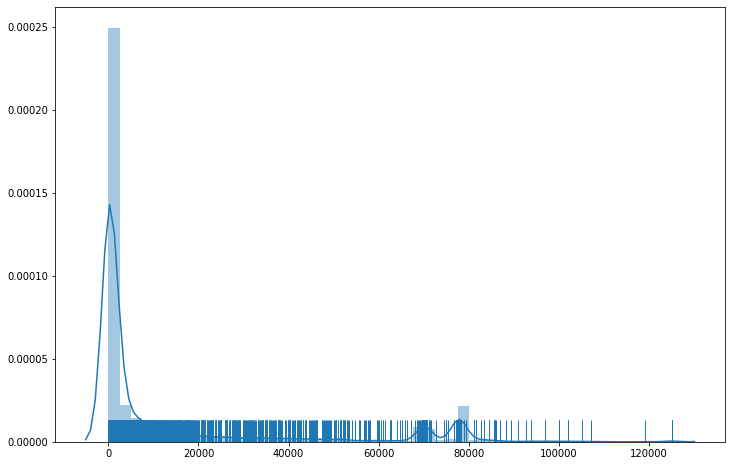

In [80]:
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
seaborn.distplot(list(pmhc_to_aff.values()), rug=True)

In [82]:
(np.array(list(pmhc_to_aff.values())) > 10**4).mean()

0.2588200415060777

In [95]:
df_r = pd.read_csv("mhc_sars2_purified_competitive_radioactivity.csv").set_index(["allele", "peptide"])
df_f = pd.read_csv("mhc_sars2_purified_direct_fluorescence.csv").set_index(["allele", "peptide"])

In [101]:
joined = df_r.join(df_f, how="inner", lsuffix="_r", rsuffix="_f")

In [103]:
r_null = joined["affinity_r"].isnull()
f_null = joined["affinity_f"].isnull()
either_null = r_null | f_null
neither_null = ~either_null
joined[neither_null]

affinity_r  affinity_f
allele      peptide                          
HLA-A*03:01 MTNRQFHQK       21.50       88.24
            KMQRMLLEK        6.98      304.95
            YIFFASFYY        2.26     1004.67
HLA-A*11:01 VVYRGTTTY      108.00      117.17
HLA-A*03:01 AVLQSGFRK        6.78      258.85
HLA-A*11:01 KLFAAETLK       20.90      233.75
HLA-A*03:01 KLFAAETLK       11.60      375.87
HLA-A*31:01 KLFAAETLK       80.50      173.00
HLA-A*03:01 KTFPPTEPK      287.00      186.22
HLA-A*11:01 YIFFASFYY        0.41      346.95
HLA-A*03:01 VVYRGTTTY        7.73       42.06
HLA-A*11:01 AVLQSGFRK       10.30       80.10
            MTNRQFHQK        4.95      144.95
HLA-A*03:01 ATVVIGTSK      186.00      231.85
HLA-A*11:01 KTFPPTEPK      527.00       69.82
            GVAMPNLYK        2.73       72.82
            SSNVANYQK       48.50       22.92
HLA-A*31:01 AVLQSGFRK       21.20      186.50
HLA-A*11:01 KMQRMLLEK        4.39      340.80
HLA-A*03:01 ALRANSAVK       18.20      197.12
HLA-A*11:01 ATVVIGTSK        3.15       30.13
HLA-A*31:01 KTFPPTEPK      166.00       96.33
            ALRANSAVK     1600.00      479.00
HLA-A*03:01 GVAMPNLYK        4.08       59.92
HLA-A*11:01 ALRANSAVK     2480.00     1760.00
HLA-A*03:01 SSNVANYQK     1760.00      442.07